# AlphaCapture Strategy

## Requirements

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report

## Data Collection

In [3]:
# example tickers
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']

# download data
data = yf.download(tickers, start='2020-01-01', end='2023-01-01')['Adj Close']

# calculate daily returns
returns = data.pct_change()

# additional technical indicators
for ticker in tickers:
    data[f'{ticker}_SMA_20'] = data[ticker].rolling(window=20).mean()
    data[f'{ticker}_SMA_50'] = data[ticker].rolling(window=50).mean()
    data[f'{ticker}_EMA_20'] = data[ticker].ewm(span=20, adjust=False).mean()
    data[f'{ticker}_Momentum'] = returns[ticker].rolling(window=20).mean()

# merge all indicators into a single df
indicators = pd.concat([data, returns.rename(columns={ticker: f'{ticker}_Returns' for ticker in tickers})], axis=1)
indicators.tail()

[*********************100%%**********************]  5 of 5 completed


Ticker,AAPL,AMZN,GOOGL,META,MSFT,AAPL_SMA_20,AAPL_SMA_50,AAPL_EMA_20,AAPL_Momentum,MSFT_SMA_20,...,AMZN_Momentum,META_SMA_20,META_SMA_50,META_EMA_20,META_Momentum,AAPL_Returns,AMZN_Returns,GOOGL_Returns,META_Returns,MSFT_Returns
Date,,,,,,,,,,,,,,,,,,,,,
2022-12-23,130.782593,85.250000,89.230003,117.914894,235.769745,139.511658,142.881867,138.074890,-0.005587,244.105106,...,-0.004312,116.900967,114.162672,116.513482,0.003421,-0.002798,0.017425,0.016750,0.007855,0.002267
2022-12-27,128.967514,83.040001,87.389999,116.756119,234.021729,138.807954,142.720777,137.207521,-0.004967,243.868082,...,-0.005898,117.305538,113.965282,116.536590,0.004110,-0.013879,-0.025924,-0.020621,-0.009827,-0.007414
2022-12-28,125.010124,81.820000,86.019997,115.497459,231.621857,138.057636,142.400731,136.045864,-0.005444,243.581679,...,-0.005818,117.613211,113.597272,116.437625,0.003259,-0.030685,-0.014692,-0.015677,-0.010780,-0.010255
2022-12-29,128.550964,84.180000,88.449997,120.132538,238.021484,137.144162,142.124964,135.332064,-0.006458,242.883939,...,-0.006605,117.721097,113.346738,116.789522,0.001319,0.028324,0.028844,0.028249,0.040131,0.027630
2022-12-30,128.868332,84.000000,88.230003,120.212448,236.846252,136.232670,141.853366,134.716471,-0.006429,242.149659,...,-0.006173,117.716102,113.089211,117.115515,0.000361,0.002469,-0.002138,-0.002487,0.000665,-0.004938


## Feature Engineering

In [4]:
# download assuming volume data is available
volume_data = yf.download(tickers, start='2020-01-01', end='2023-01-01')['Volume']

# calculate volatility and volume based indicators
for ticker in tickers:
    indicators[f'{ticker}_Volatility'] = returns[ticker].rolling(window=20).std()
    indicators[f'{ticker}_Volume'] = volume_data[ticker]
    indicators[f'{ticker}_Volume_SMA_20'] = volume_data[ticker].rolling(window=20).mean()

indicators.tail()

[*********************100%%**********************]  5 of 5 completed


Ticker,AAPL,AMZN,GOOGL,META,MSFT,AAPL_SMA_20,AAPL_SMA_50,AAPL_EMA_20,AAPL_Momentum,MSFT_SMA_20,...,MSFT_Volume_SMA_20,GOOGL_Volatility,GOOGL_Volume,GOOGL_Volume_SMA_20,AMZN_Volatility,AMZN_Volume,AMZN_Volume_SMA_20,META_Volatility,META_Volume,META_Volume_SMA_20
Date,,,,,,,,,,,,,,,,,,,,,
2022-12-23,130.782593,85.250000,89.230003,117.914894,235.769745,139.511658,142.881867,138.074890,-0.005587,244.105106,...,30291625.0,0.021728,23003000,30306710.0,0.022832,57433700,77979990.0,0.033315,17796600,33031110.0
2022-12-27,128.967514,83.040001,87.389999,116.756119,234.021729,138.807954,142.720777,137.207521,-0.004967,243.868082,...,29887145.0,0.021924,20097300,29999700.0,0.023192,57284000,77097035.0,0.032866,21392300,32935255.0
2022-12-28,125.010124,81.820000,86.019997,115.497459,231.621857,138.057636,142.400731,136.045864,-0.005444,243.581679,...,29862185.0,0.022047,19523200,29972775.0,0.023157,58228600,76730100.0,0.033028,19612500,32720920.0
2022-12-29,128.550964,84.180000,88.449997,120.132538,238.021484,137.144162,142.124964,135.332064,-0.006458,242.883939,...,28471010.0,0.017700,23333500,28957075.0,0.021568,54995900,74339605.0,0.029275,22366200,31671800.0
2022-12-30,128.868332,84.000000,88.230003,120.212448,236.846252,136.232670,141.853366,134.716471,-0.006429,242.149659,...,28265860.0,0.017661,23986300,28722035.0,0.021566,62401200,74035265.0,0.028950,19583800,30823420.0


## ML for Signal Generation

In [5]:
# prep data for ML
features = indicators.drop(columns=['AAPL_Returns','GOOGL_Returns','AMZN_Returns','META_Returns','MSFT_Returns'])
target = (returns > 0).astype(int)  # Binary target: 1 if return is positive, else 0

# drow rows with NaN values
print(features.isnull().sum()) # check for NaN values
features = features.dropna()
target = target.reindex(features.index)

# train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=False)

# train RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# predict signals
predictions = model.predict(X_test)

# evaluate the model
print(classification_report(y_test, predictions))

Ticker
AAPL                    0
AMZN                    0
GOOGL                   0
META                    0
MSFT                    0
AAPL_SMA_20            19
AAPL_SMA_50            49
AAPL_EMA_20             0
AAPL_Momentum          20
MSFT_SMA_20            19
MSFT_SMA_50            49
MSFT_EMA_20             0
MSFT_Momentum          20
GOOGL_SMA_20           19
GOOGL_SMA_50           49
GOOGL_EMA_20            0
GOOGL_Momentum         20
AMZN_SMA_20            19
AMZN_SMA_50            49
AMZN_EMA_20             0
AMZN_Momentum          20
META_SMA_20            19
META_SMA_50            49
META_EMA_20             0
META_Momentum          20
AAPL_Volatility        20
AAPL_Volume             0
AAPL_Volume_SMA_20     19
MSFT_Volatility        20
MSFT_Volume             0
MSFT_Volume_SMA_20     19
GOOGL_Volatility       20
GOOGL_Volume            0
GOOGL_Volume_SMA_20    19
AMZN_Volatility        20
AMZN_Volume             0
AMZN_Volume_SMA_20     19
META_Volatility        20
META_

/Users/euge/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/euge/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Backtesting with Transaction Costs

Total Returns (AAPL): 3.81%
Total Returns (AMZN): -10.96%
Total Returns (GOOGL): -19.46%
Total Returns (META): 10.23%
Total Returns (MSFT): -9.80%


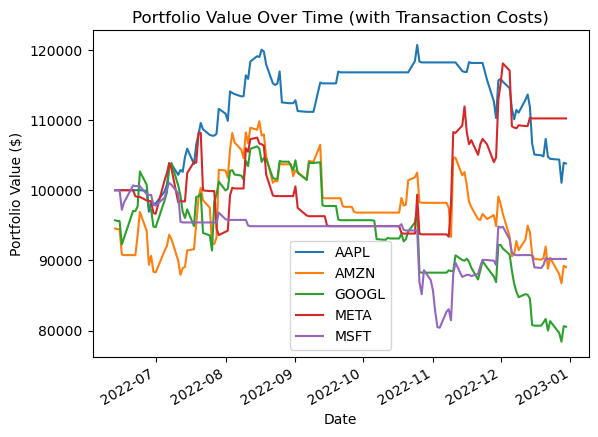

In [6]:
# define transaction cost
transaction_cost = 0.001  # 0.1%

# generate signals
signals = pd.DataFrame(predictions, index=X_test.index, columns=['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META'])

# calculate positions
positions = signals.shift(1)

# calculate portfolio returns considering transaction costs
portfolio_returns = positions * returns.loc[X_test.index] - transaction_cost * np.abs(positions.diff())

# calculate cumulative portfolio value
initial_capital = 100000
portfolio_value = (1 + portfolio_returns).cumprod() * initial_capital

total_returns = (portfolio_value.iloc[-1] - initial_capital) / initial_capital
for stock in total_returns.index:
    print(f"Total Returns ({stock}): {total_returns[stock]:.2%}")

# plot portfolio value over time
portfolio_value.plot()
plt.title('Portfolio Value Over Time (with Transaction Costs)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.show()

## Performance Metrics

Sharpe Ratio (AAPL): 0.42
Sharpe Ratio (AMZN): -0.11
Sharpe Ratio (GOOGL): -0.82
Sharpe Ratio (META): 0.69
Sharpe Ratio (MSFT): -0.69
Max Drawdown (AAPL): -16.28%
Max Drawdown (AMZN): -21.03%
Max Drawdown (GOOGL): -26.20%
Max Drawdown (META): -13.69%
Max Drawdown (MSFT): -20.43%


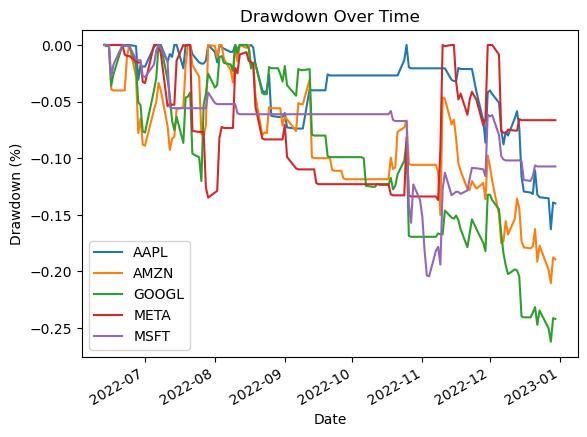

In [9]:
# calculate Sharpe Ratio
portfolio_returns = portfolio_value.pct_change().dropna()
sharpe_ratio = (portfolio_returns.mean() / portfolio_returns.std()) * np.sqrt(252)

for asset in sharpe_ratio.index:
    print(f"Sharpe Ratio ({asset}): {sharpe_ratio[asset]:.2f}")

# calculate maximum drawdown
rolling_max = portfolio_value.cummax()
drawdown = (portfolio_value - rolling_max) / rolling_max
max_drawdown = drawdown.min()

for asset in max_drawdown.index:
    print(f"Max Drawdown ({asset}): {max_drawdown[asset]:.2%}")

# plot drawdown
drawdown.plot()
plt.title('Drawdown Over Time')
plt.xlabel('Date')
plt.ylabel('Drawdown (%)')
plt.show()


## Optimization and Hyperparameter Tuning

In [10]:
# define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
}

# grid search
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")

Best parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 50}


## Risk Management

Total Returns: 38.43%


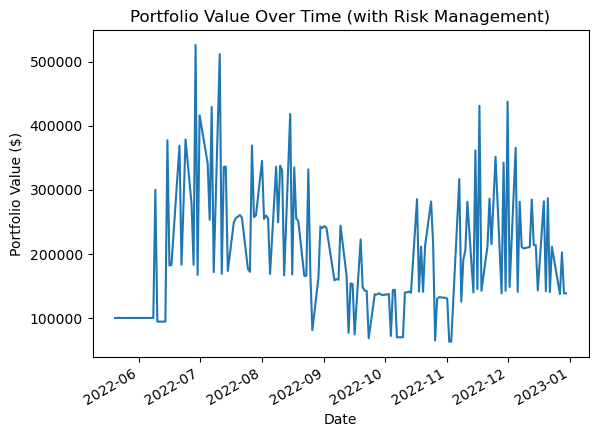

In [12]:
# define stop-loss and take-profit thresholds
stop_loss = 0.02  # 2%
take_profit = 0.05  # 5%

# initialize variables
capital = initial_capital
positions = {ticker: 0 for ticker in tickers}
portfolio_value = []

# reindex signals to match data index
signals = signals.reindex(data.index, method='pad').fillna(0)

for i in range(1, len(signals)):
    current_date = signals.index[i]
    current_prices = data.loc[current_date]
    
    for ticker in tickers:
        if positions[ticker] == 0:  # no current position
            if signals[ticker].iloc[i] == 1:
                positions[ticker] = capital / current_prices[ticker]
                buy_price = current_prices[ticker]
        else:  # current position exists
            if current_prices[ticker] >= buy_price * (1 + take_profit) or current_prices[ticker] <= buy_price * (1 - stop_loss):
                capital = positions[ticker] * current_prices[ticker] - transaction_cost * positions[ticker] * current_prices[ticker]
                positions[ticker] = 0
    
    portfolio_value.append(capital + sum(positions[ticker] * current_prices[ticker] for ticker in tickers))

# convert to series for easier handling
portfolio_value = pd.Series(portfolio_value, index=data.index[1:])

print(f"Total Returns: {(portfolio_value.iloc[-1] - initial_capital) / initial_capital:.2%}")

# plot portfolio value over time with risk management
start_date = '2022-05-20'
portfolio_value[start_date:].plot()
plt.title('Portfolio Value Over Time (with Risk Management)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.show()